In [1]:
### Data Pre-Processing ###

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
sns.set_style('whitegrid')
import missingno as msno
%matplotlib inline

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Import the data
data = pd.read_csv('/Users/adorex/Downloads/University of Warwick/e-BM/4⃣️ Machine Learning & Data Engineering/PMA/Data/default_data.csv')
data.head()

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,lump_sum_payment,property_value,Secured_by,total_units,income,Credit_Score,age,LTV,Region,Status
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,...,not_lpsm,118000.0,home,1U,1740.0,758,25-34,98.728814,south,1
1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,...,lpsm,NaN,home,1U,4980.0,552,55-64,NaN,North,1
2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,...,not_lpsm,508000.0,home,1U,9480.0,834,35-44,80.019685,south,0
3,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,not_lpsm,658000.0,home,1U,11880.0,587,45-54,69.376900,North,0
4,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,not_lpsm,758000.0,home,1U,10440.0,602,25-34,91.886544,North,0


In [2]:
# View the attributes with more than 20% missing value percentage
check_null = data.isnull().sum(axis=0).sort_values(ascending=False)/float(len(data))
print(check_null[check_null > 0.2])

Upfront_charges     0.266644
rate_of_interest    0.245100
dtype: float64


In [3]:
# Set a threshold to delete the fields with more than 30% missing values
thresh_count = len(data)*0.3
data = data.dropna(thresh=thresh_count, axis=1)

In [4]:
# Separately count data types
data.dtypes.value_counts()

object     15
float64     6
int64       5
dtype: int64

In [5]:
# Exclude the variables with one classification
data = data.loc[:,data.apply(pd.Series.nunique) != 1]

In [6]:
# Count the number of missing values in categorical variables and output in descending order
objectColumns = data.select_dtypes(include=["object"]).columns
data[objectColumns].isnull().sum().sort_values(ascending=False)

loan_limit                3344
approv_in_adv              908
age                        200
loan_purpose               134
Neg_ammortization          121
Gender                       0
loan_type                    0
Credit_Worthiness            0
open_credit                  0
business_or_commercial       0
interest_only                0
lump_sum_payment             0
Secured_by                   0
total_units                  0
Region                       0
dtype: int64

<AxesSubplot:>

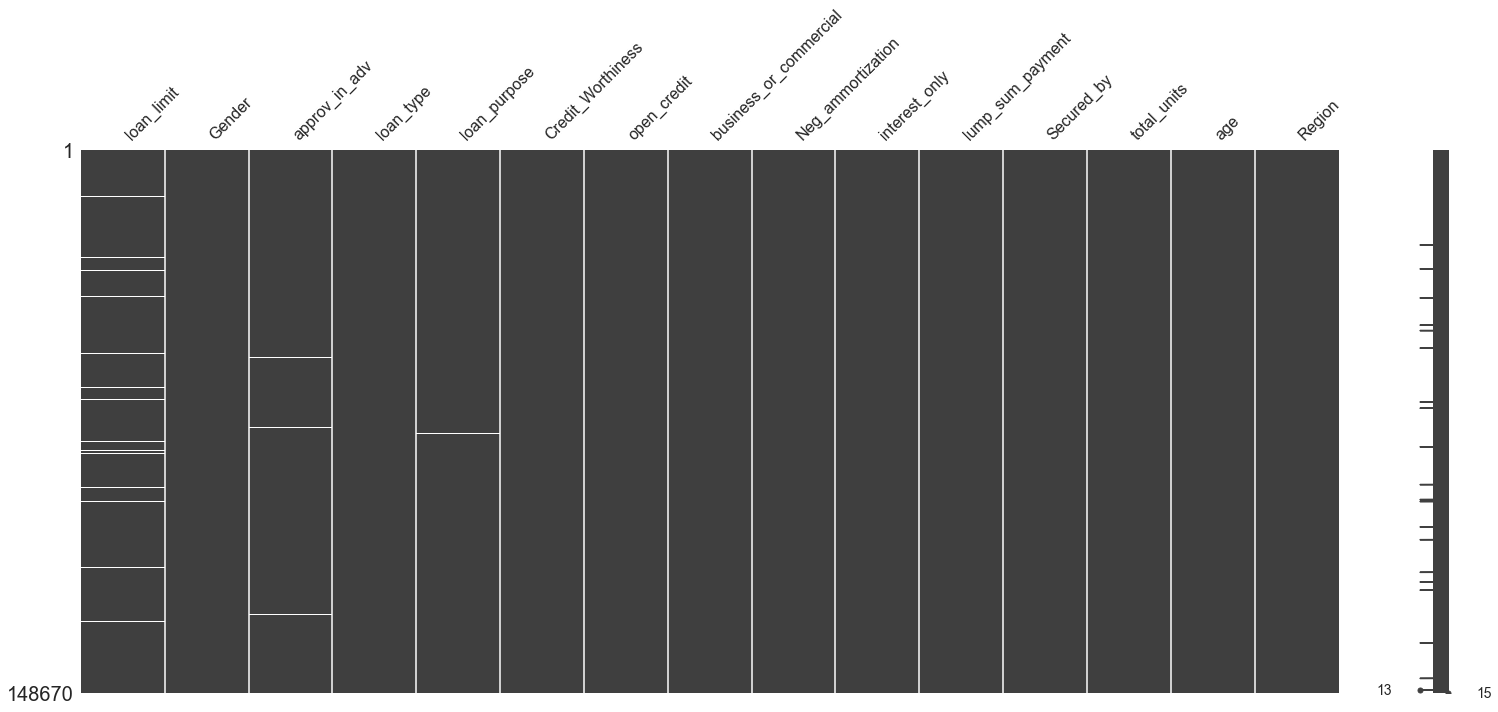

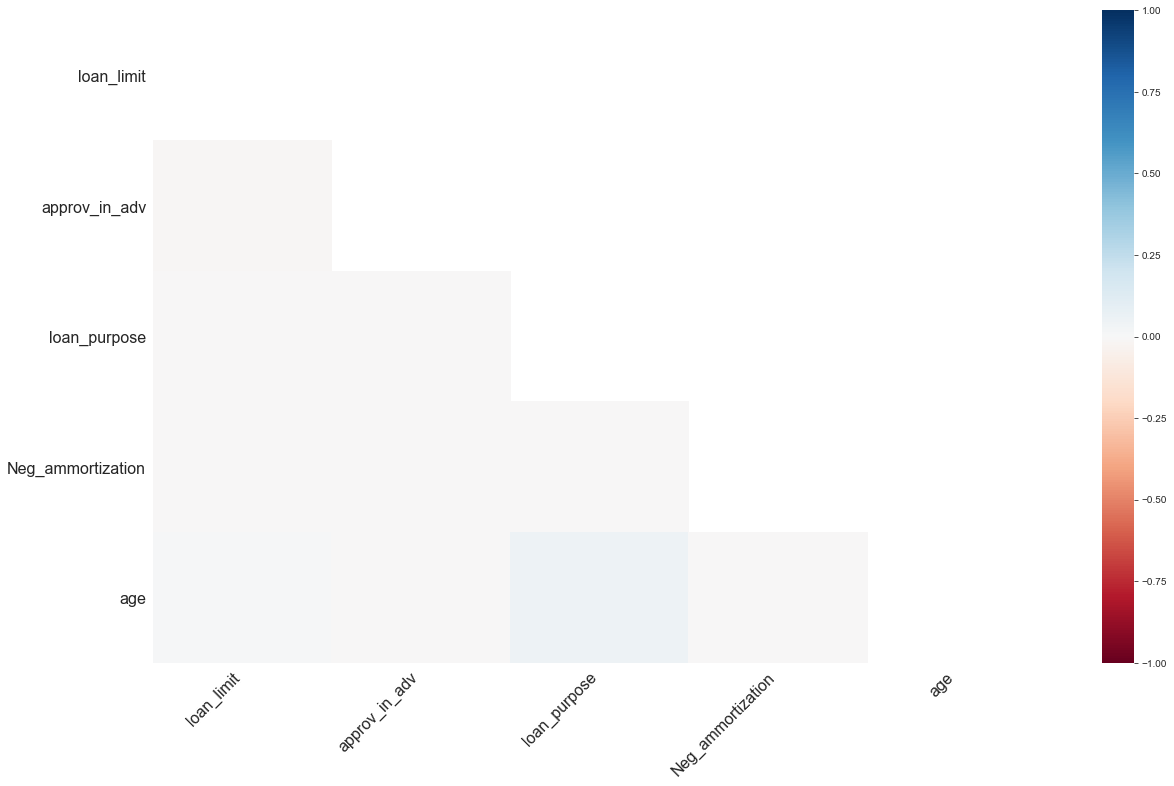

In [7]:
# Visualise missing values in categorical variables
msno.matrix(data[objectColumns])

# View correlation between missing values in categorical variables
msno.heatmap(data[objectColumns])

<AxesSubplot:>

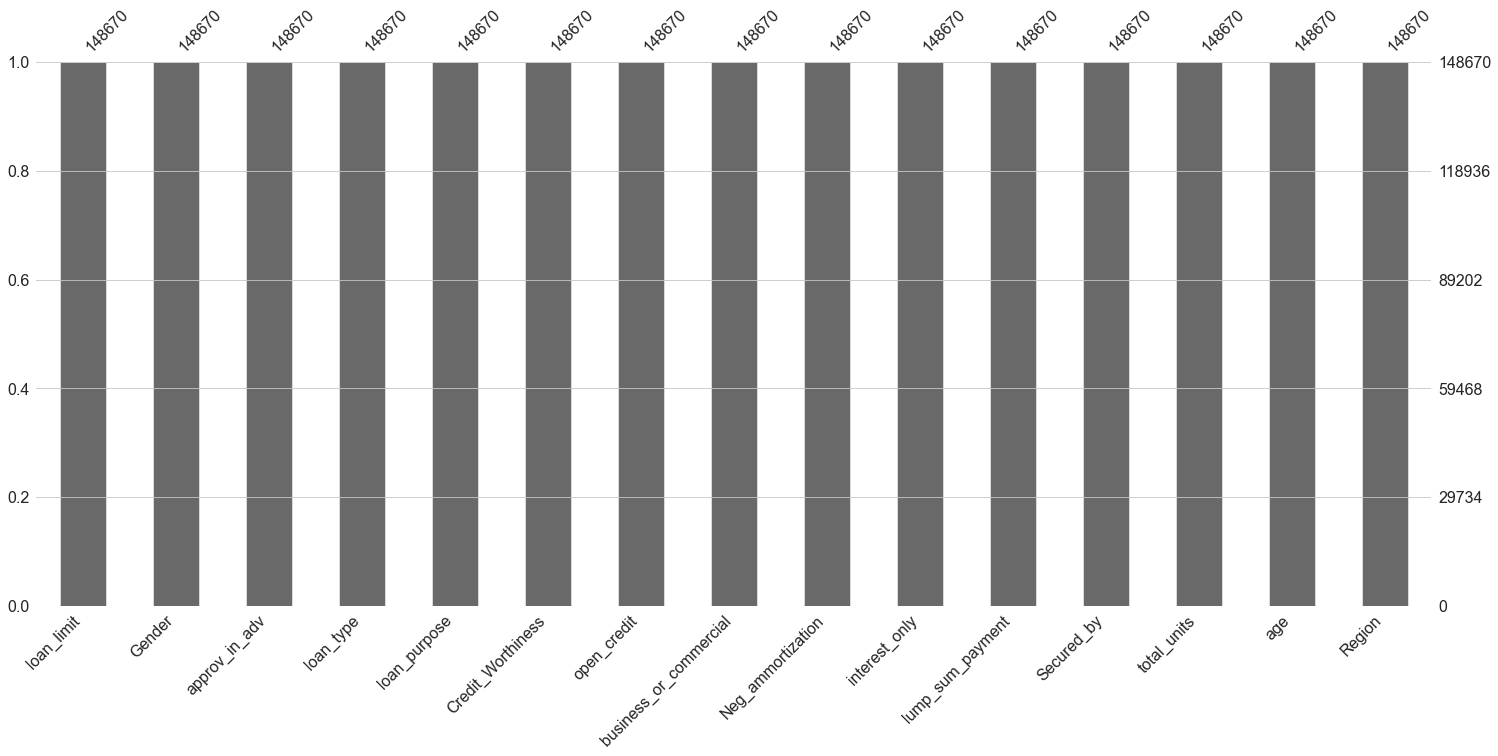

In [8]:
# Create a category "Unknown" for missing values of categorical variables
objectColumns = data.select_dtypes(include=["object"]).columns
data[objectColumns] = data[objectColumns].fillna("Unknown")

# View again in bar chart
msno.bar(data[objectColumns])

In [9]:
# Count the number of missing values in numerical variables and output in descending order
data.select_dtypes(include=[np.number]).isnull().sum().sort_values(ascending=False)

Upfront_charges     39642
rate_of_interest    36439
property_value      15098
LTV                 15098
income               9150
term                   41
ID                      0
loan_amount             0
Credit_Score            0
Status                  0
dtype: int64

<AxesSubplot:>

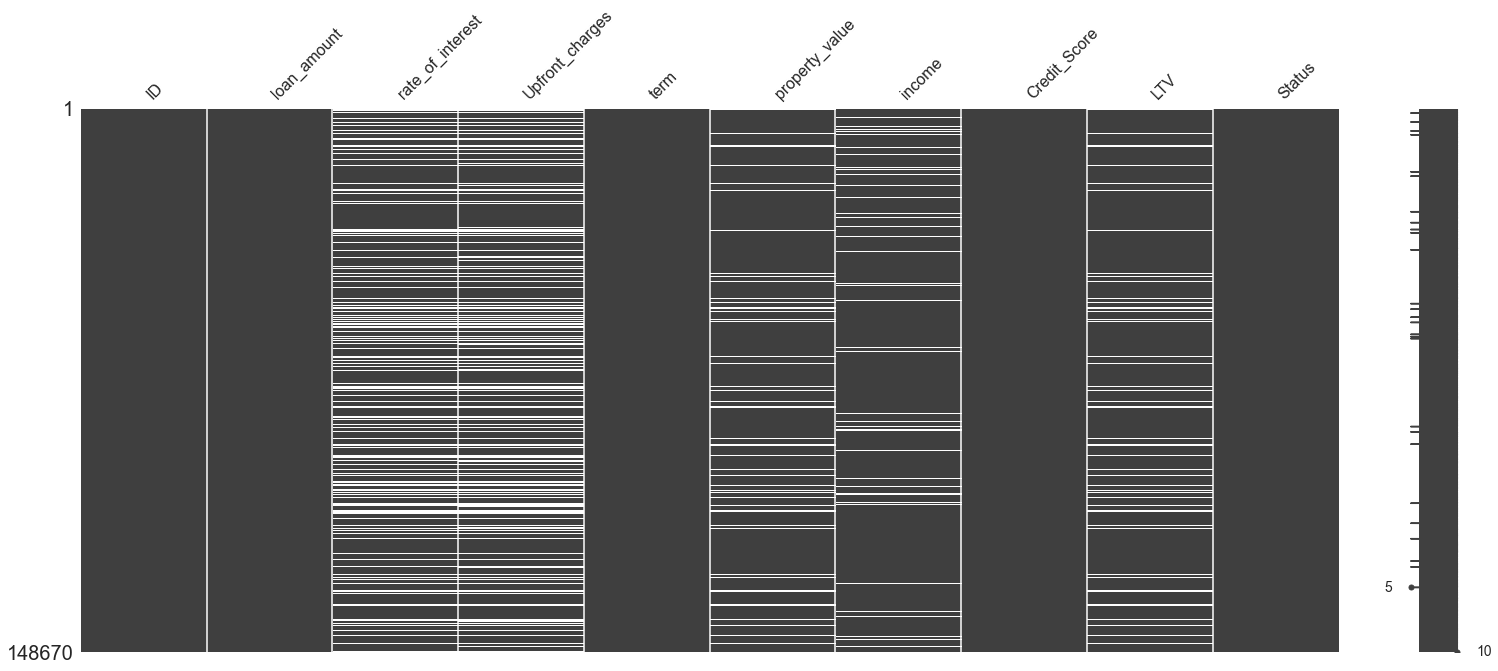

In [10]:
# Visualise missing values in numerical variables
numColumns = data.select_dtypes(include=[np.number]).columns
msno.matrix(data[numColumns])

<AxesSubplot:>

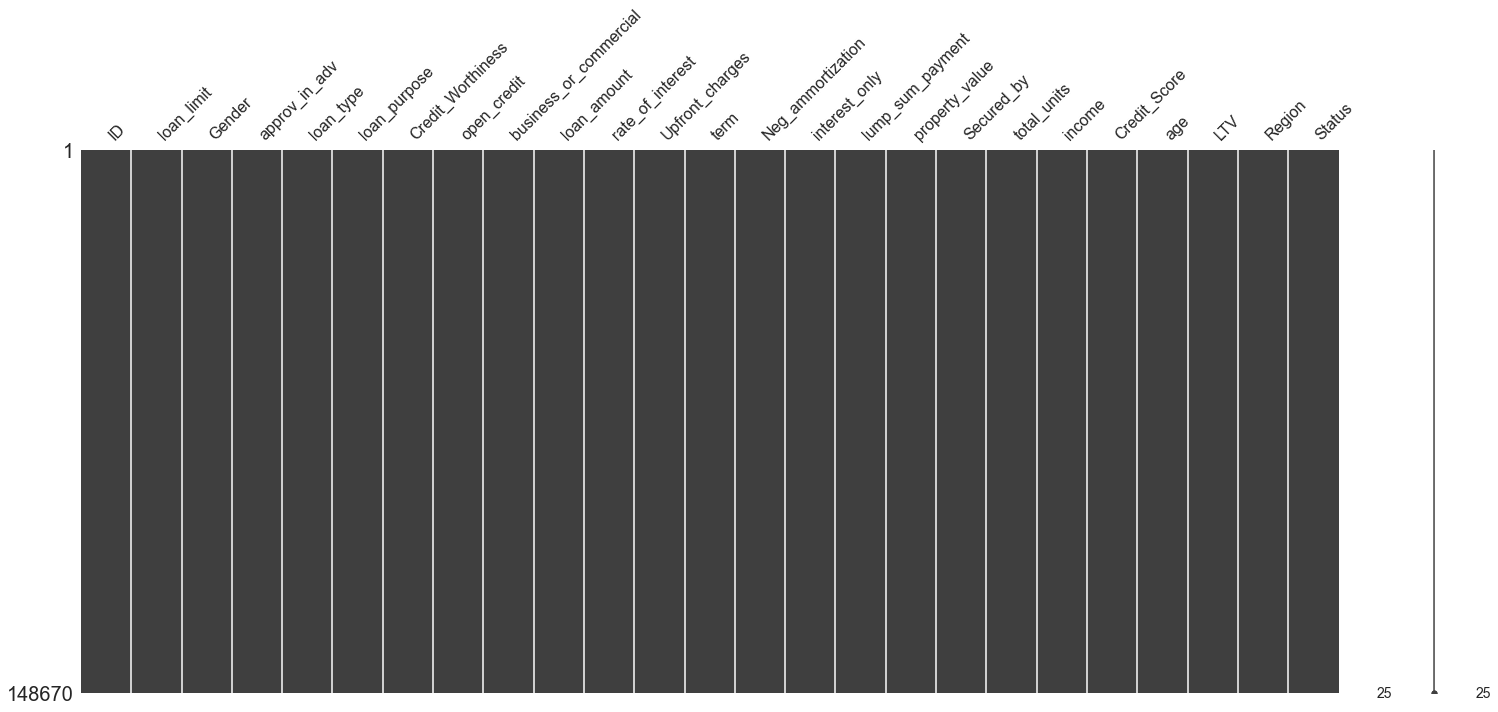

In [11]:
# Fill in missing values by median imputation
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='median')
imp = imp.fit(data[numColumns])
data[numColumns] = imp.transform(data[numColumns])
# this example taken from: https://scikit-learn.org/stable/modules/impute.html#univariate-feature-imputation

# Check again for missing values
msno.matrix(data) 

In [12]:
# Count value frequency of categorical variables
objectColumns = data.select_dtypes(include=["object"]).columns
var = data[objectColumns].columns
for v in var:
    print('\nFrequency count for variable {0}'.format(v))
    print(data[v].value_counts())
data[objectColumns].shape


Frequency count for variable loan_limit
cf         135348
ncf          9978
Unknown      3344
Name: loan_limit, dtype: int64

Frequency count for variable Gender
Male                 42346
Joint                41399
Sex Not Available    37659
Female               27266
Name: Gender, dtype: int64

Frequency count for variable approv_in_adv
nopre      124621
pre         23141
Unknown       908
Name: approv_in_adv, dtype: int64

Frequency count for variable loan_type
type1    113173
type2     20762
type3     14735
Name: loan_type, dtype: int64

Frequency count for variable loan_purpose
p3         55934
p4         54799
p1         34529
p2          3274
Unknown      134
Name: loan_purpose, dtype: int64

Frequency count for variable Credit_Worthiness
l1    142344
l2      6326
Name: Credit_Worthiness, dtype: int64

Frequency count for variable open_credit
nopc    148114
opc        556
Name: open_credit, dtype: int64

Frequency count for variable business_or_commercial
nob/c    127908
b/c   

(148670, 15)

In [13]:
drop_list = ['Credit_Worthiness']
data.drop(drop_list, axis=1, inplace = True)
data.select_dtypes(include = ['object']).shape

(148670, 14)

In [14]:
### Feature Engineering ###

# 1.Feature abstraction

# Use Pandas replace function to define new function:
def coding(col, codeDict):
    colCoded = pd.Series(col, copy=True)
    for key, value in codeDict.items():
        colCoded.replace(key, value, inplace=True)
    return colCoded

# Encode loan status, Default=1, No Default=0:
pd.value_counts(data["Status"])
data["Status"] = coding(data["Status"], {'0':0,'1':1})   
print( 'After Coding:')
pd.value_counts(data["Status"])

After Coding:


0.0    112031
1.0     36639
Name: Status, dtype: int64

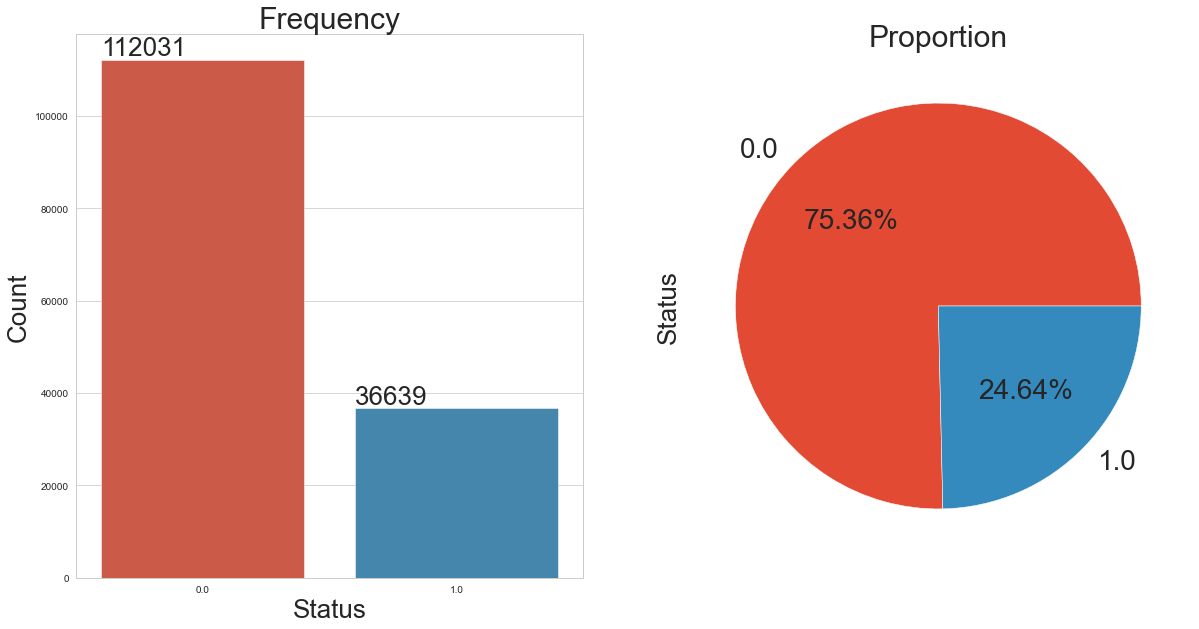

In [15]:
# Visualise loan status distribution
fig, axs = plt.subplots(1,2,figsize=(20,10))
sns.countplot(x='Status',data=data,ax=axs[0])
for nc in axs[0].patches:
    axs[0].annotate(f'{nc.get_height()}', (nc.get_x(), nc.get_height()+1000), size=26)
axs[0].set_title("Frequency",fontsize=30)
axs[0].set_xlabel("Status",fontsize=26)
axs[0].set_ylabel("Count",fontsize=26)
data['Status'].value_counts().plot(kind='pie', ax=axs[1],autopct='%1.2f%%',fontsize=28)
axs[1].set_title("Proportion",fontsize=30)
axs[1].set_ylabel("Status",fontsize=26)
plt.show()

In [16]:
# Check the example detail of object columns
data.select_dtypes(include=["object"]).describe().T

,count,unique,top,freq
loan_limit,148670,3,cf,135348
Gender,148670,4,Male,42346
approv_in_adv,148670,3,nopre,124621
loan_type,148670,3,type1,113173
loan_purpose,148670,5,p3,55934
open_credit,148670,2,nopc,148114
business_or_commercial,148670,2,nob/c,127908
Neg_ammortization,148670,3,not_neg,133420
interest_only,148670,2,not_int,141560
lump_sum_payment,148670,2,not_lpsm,145286


In [17]:
# One-hot encoding with get_dummies
n_columns = ["loan_limit", "Gender", "age","Region",
             "approv_in_adv","loan_type", "loan_purpose",
             "open_credit","business_or_commercial","Neg_ammortization",
             "interest_only","lump_sum_payment","Secured_by","total_units"] 
dummy_df = pd.get_dummies(data[n_columns])
data = pd.concat([data, dummy_df], axis=1)
# axis = 1 means the two tables are combined in a row-aligned manner

In [18]:
# Clear the original categorical variables
data = data.drop(n_columns, axis=1)

In [19]:
# View data information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 57 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   ID                            148670 non-null  float64
 1   loan_amount                   148670 non-null  float64
 2   rate_of_interest              148670 non-null  float64
 3   Upfront_charges               148670 non-null  float64
 4   term                          148670 non-null  float64
 5   property_value                148670 non-null  float64
 6   income                        148670 non-null  float64
 7   Credit_Score                  148670 non-null  float64
 8   LTV                           148670 non-null  float64
 9   Status                        148670 non-null  float64
 10  loan_limit_Unknown            148670 non-null  uint8  
 11  loan_limit_cf                 148670 non-null  uint8  
 12  loan_limit_ncf                148670 non-nul

In [20]:
# 2.Feature scaling

# Exclude the target variable
col = data.select_dtypes(include=['int64','float64']).columns
col = col.drop('Status')

# Copy data to variable loans_ml_df
loans_ml_df = data

# Data standardisation
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
loans_ml_df[col] =sc.fit_transform(loans_ml_df[col])

,ID,loan_amount,rate_of_interest,Upfront_charges,term,property_value,income,Credit_Score,LTV,Status,...,interest_only_int_only,interest_only_not_int,lump_sum_payment_lpsm,lump_sum_payment_not_lpsm,Secured_by_home,Secured_by_land,total_units_1U,total_units_2U,total_units_3U,total_units_4U
0,-1.732039,-1.166980,-0.085756,-0.164744,0.425609,-1.087010,-0.816446,0.502357,0.679317,1.0,...,0,1,0,1,1,0,1,0,0,0
1,-1.732016,-0.677607,-0.085756,-0.164744,0.425609,-0.209870,-0.302164,-1.275413,0.056657,1.0,...,0,1,1,0,1,0,1,0,0,0
2,-1.731993,0.409890,1.081449,-0.880068,0.425609,0.053272,0.412116,1.158234,0.185549,0.0,...,0,1,0,1,1,0,1,0,0,0
3,-1.731969,0.681764,0.446653,-0.164744,0.425609,0.491841,0.793066,-0.973365,-0.095333,0.0,...,0,1,0,1,1,0,1,0,0,0
4,-1.731946,1.986759,-0.065279,-1.092723,0.425609,0.784221,0.564496,-0.843916,0.498737,0.0,...,0,1,0,1,1,0,1,0,0,0


In [21]:
# 3.Feature selection

# Construct feature variable X and target variable Y
x_feature = list(loans_ml_df.columns)
x_feature.remove('Status')
x_val = loans_ml_df[x_feature]
y_val = loans_ml_df['Status']

In [22]:
# Wrapper approach

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Build logistic regression classifier
model = LogisticRegression()

# Create recursive feature elimination filters: select 30 features by recursive selection
rfe = RFE(estimator=model, n_features_to_select=30,step=1)
rfe = rfe.fit(x_val, y_val)
print(rfe.support_)
print(rfe.ranking_)   #'1' means selected, others are unselected

# this example taken from: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html

[False False  True  True False  True False False False False False  True
  True False  True  True  True  True False False False False False  True
 False  True  True False  True False False  True  True False False False
  True False False False  True  True  True False  True  True  True False
  True  True  True  True  True  True  True  True]
[27  3  1  1 24  1  4 26 11 17 22  1  1 14  1  1  1  1  6  8  9  7 18  1
 23  1  1 12  1 13 20  1  1 16 25 21  1 15  2 19  1  1  1 10  1  1  1  5
  1  1  1  1  1  1  1  1]


In [23]:
# View variables filtered by RFE
col_filter = x_val.columns[rfe.support_]
col_filter

Index(['rate_of_interest', 'Upfront_charges', 'property_value',
       'loan_limit_ncf', 'Gender_Female', 'Gender_Male',
       'Gender_Sex Not Available', 'age_25-34', 'age_35-44', 'age_Unknown',
       'Region_North-East', 'Region_central', 'approv_in_adv_Unknown',
       'loan_type_type1', 'loan_type_type2', 'loan_purpose_p2',
       'open_credit_opc', 'business_or_commercial_b/c',
       'business_or_commercial_nob/c', 'Neg_ammortization_neg_amm',
       'Neg_ammortization_not_neg', 'interest_only_int_only',
       'lump_sum_payment_lpsm', 'lump_sum_payment_not_lpsm', 'Secured_by_home',
       'Secured_by_land', 'total_units_1U', 'total_units_2U', 'total_units_3U',
       'total_units_4U'],
      dtype='object')

<AxesSubplot:title={'center':'Feature Pearson Correlation'}>

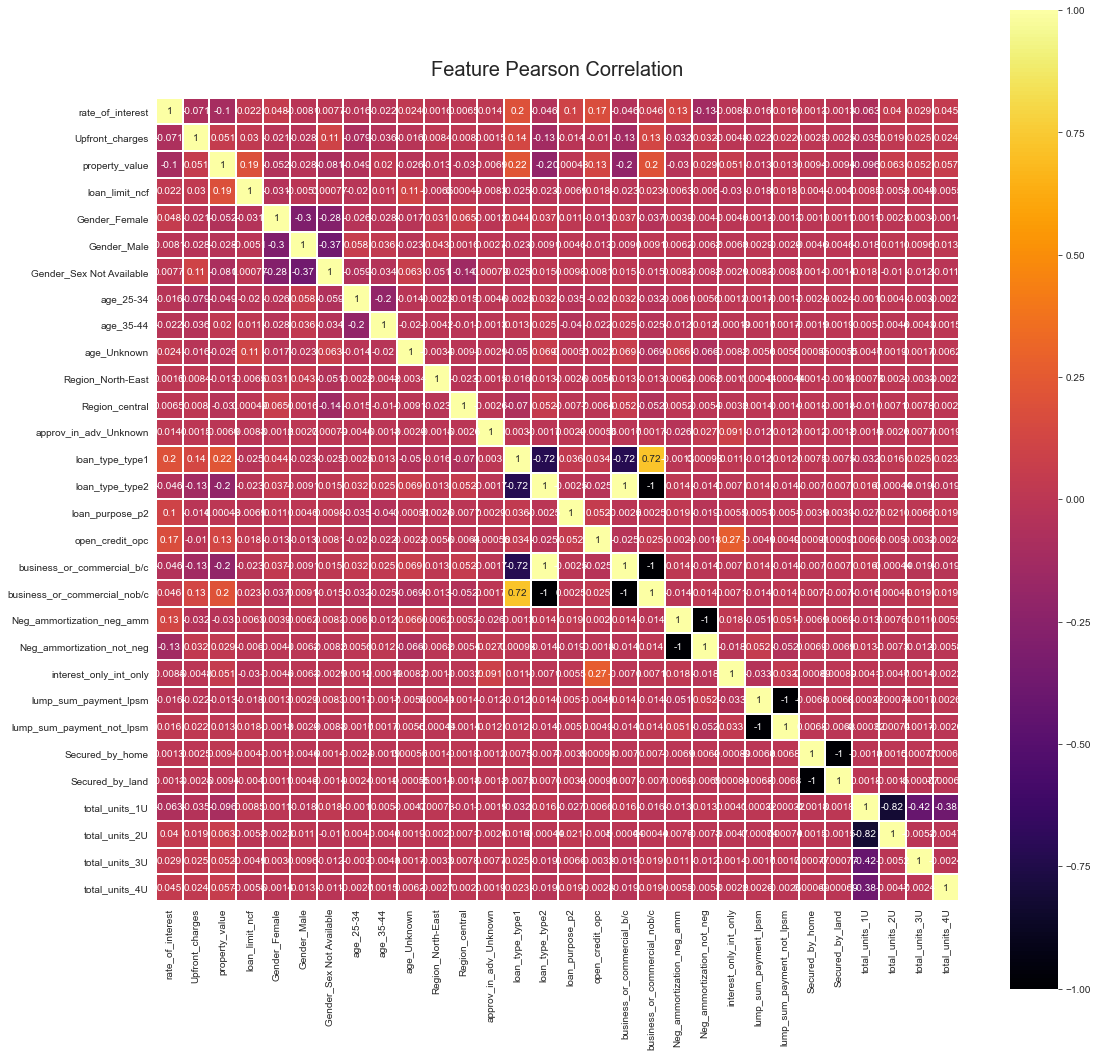

In [24]:
# Filter approach

# Draw the current Pearson correlation map
colormap = plt.cm.inferno
plt.figure(figsize=(18,18))
plt.title('Feature Pearson Correlation', y=1.02, size=20)
sns.heatmap(loans_ml_df[col_filter].corr(),
            linewidths=1, square=True, cmap=colormap, annot=True)

In [27]:
# Eliminate redundant features
drop_col = ['loan_type_type2', 
            'business_or_commercial_b/c', 
            'business_or_commercial_nob/c', 
            'Neg_ammortization_not_neg', 
            'lump_sum_payment_not_lpsm',
            'Secured_by_land', 
            'total_units_1U']
col_new = col_filter.drop(drop_col)

<AxesSubplot:title={'center':'New Feature Pearson Correlation'}>

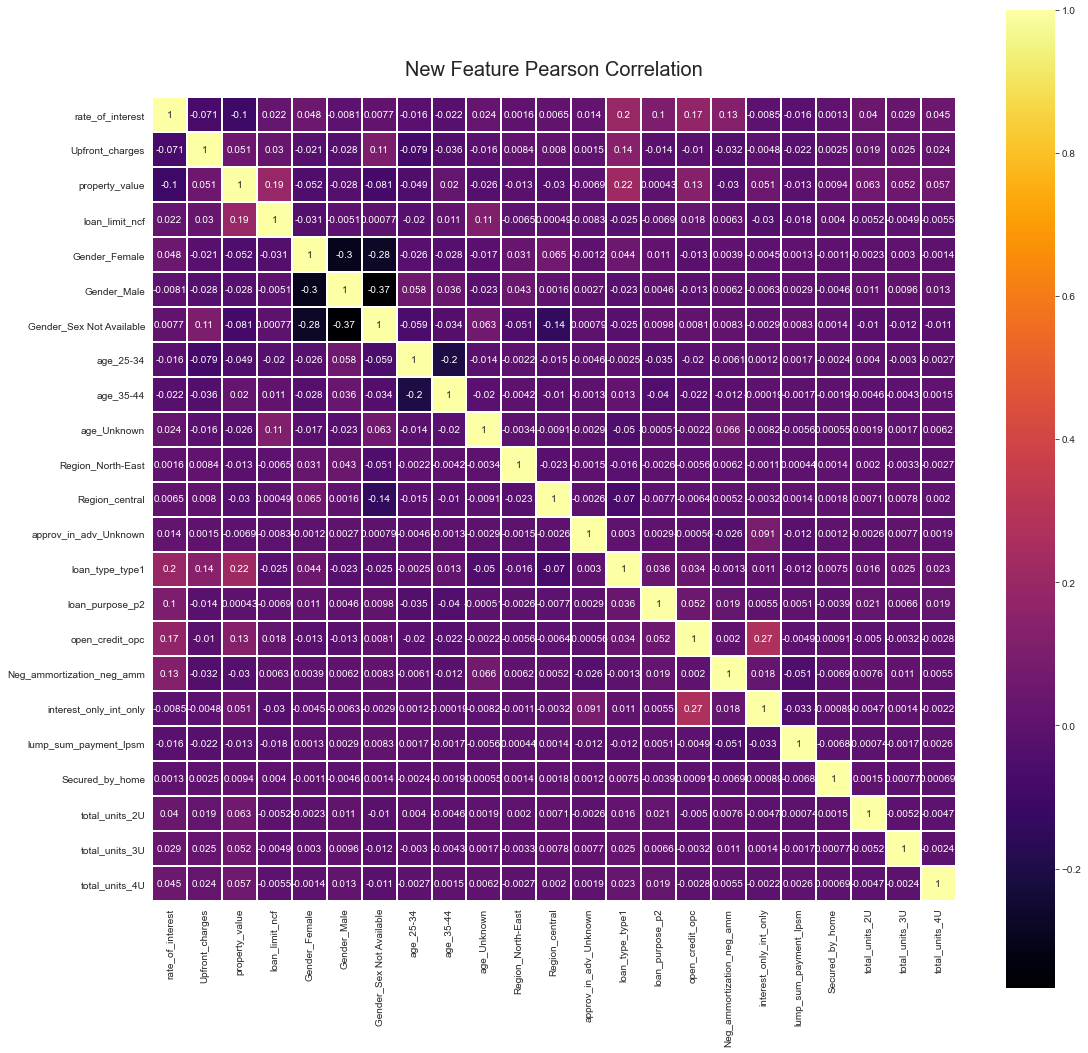

In [26]:
# Draw the new Pearson correlation map
plt.figure(figsize=(18,18))
plt.title('New Feature Pearson Correlation', y=1.02, size=20)
sns.heatmap(loans_ml_df[col_new].corr(),linewidths=1, 
            square=True, cmap=colormap, annot=True)

In [28]:
# Build random forest classifier
names = loans_ml_df[col_new].columns
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier(random_state=0)
clf.fit(x_val[col_new], y_val)
names, clf.feature_importances_
for feature in zip(names, clf.feature_importances_):
    print(feature)
    
# this example taken from: https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#

('rate_of_interest', 0.30592102404458504)
('Upfront_charges', 0.5422612348164977)
('property_value', 0.10452876791887529)
('loan_limit_ncf', 0.002372047751534548)
('Gender_Female', 0.0004913018132255686)
('Gender_Male', 0.000683540393667663)
('Gender_Sex Not Available', 0.0022093630968637898)
('age_25-34', 0.0008040129785313226)
('age_35-44', 0.000654431505063418)
('age_Unknown', 0.004073978048304747)
('Region_North-East', 0.0001714817571507181)
('Region_central', 0.00043482908157482846)
('approv_in_adv_Unknown', 0.00024003966548495523)
('loan_type_type1', 0.0037003706613601773)
('loan_purpose_p2', 0.0007392867703810989)
('open_credit_opc', 0.0017433649918245373)
('Neg_ammortization_neg_amm', 0.012484654157656714)
('interest_only_int_only', 0.001171885672862864)
('lump_sum_payment_lpsm', 0.014457573022504675)
('Secured_by_home', 0.00012446053979228917)
('total_units_2U', 0.00043605531321680815)
('total_units_3U', 0.00018153608529165033)
('total_units_4U', 0.00011475991374947267)


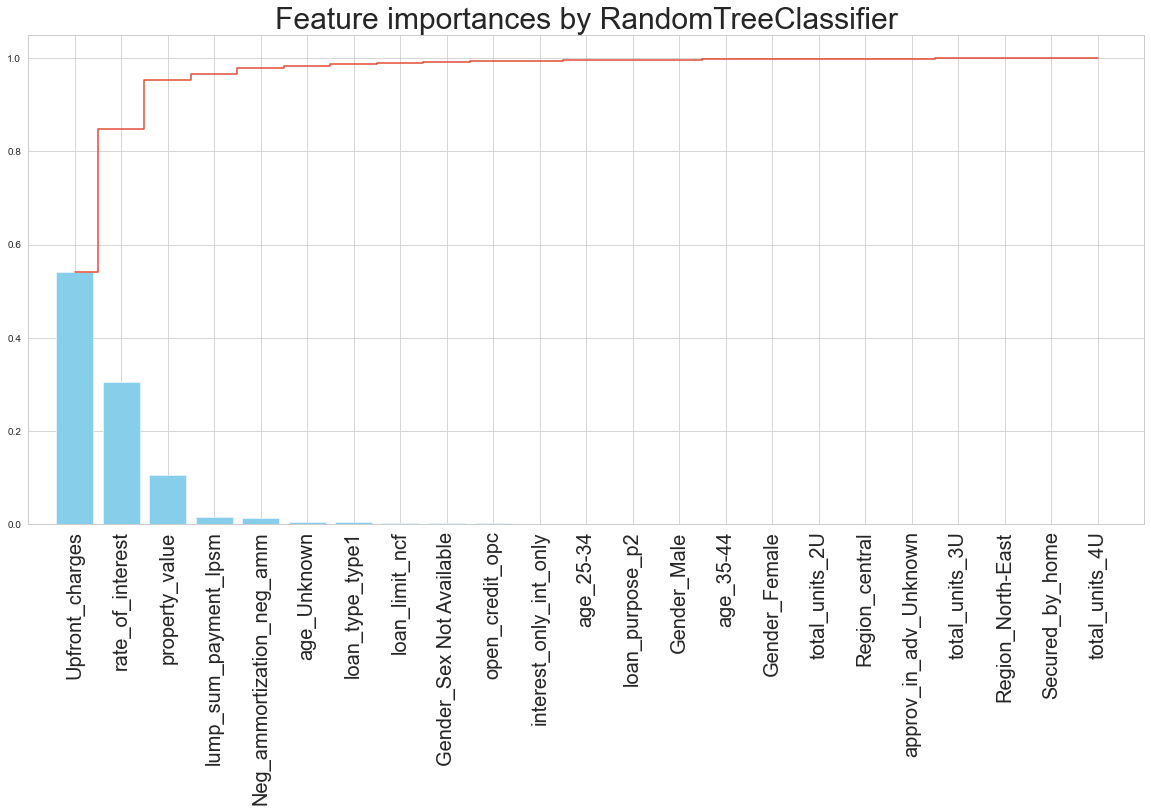

In [30]:
# Visualise feature importances
importances = clf.feature_importances_
feat_names = names
indices = np.argsort(importances)[::-1]
fig = plt.figure(figsize=(20,9))
plt.title("Feature importances by RandomTreeClassifier", fontsize=30)
plt.bar(range(len(indices)), importances[indices], color='skyblue')
plt.step(range(len(indices)), np.cumsum(importances[indices]), where='mid')
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical',fontsize=20)
plt.xlim([-1, len(indices)])
plt.show()

In [31]:
### Model Training ###

X = loans_ml_df[col_new]
y = loans_ml_df["Status"]

n_sample = y.shape[0]
n_pos_sample = y[y == 0].shape[0]
n_neg_sample = y[y == 1].shape[0]

print('Sample size：{}; Positive samples account for {:.2%}; Negative samples account for {:.2%}'.format
      (n_sample, n_pos_sample / n_sample,n_neg_sample / n_sample))
print('Feature dimension：', X.shape[1])

Sample size：148670; Positive samples account for 75.36%; Negative samples account for 24.64%
Feature dimension： 23


In [32]:
# Import SMOTE module to handle unbalanced data
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=0)
X, y = sm.fit_resample(X, y)
print('After balancing positive and negative samples by SMOTE method')
n_sample = y.shape[0]
n_pos_sample = y[y == 0].shape[0]
n_neg_sample = y[y == 1].shape[0]
print('Sample size：{}; Positive samples account for {:.2%}; Negative samples account for {:.2%}'.format
      (n_sample, n_pos_sample / n_sample, n_neg_sample / n_sample))

After balancing positive and negative samples by SMOTE method
Sample size：224062; Positive samples account for 50.00%; Negative samples account for 50.00%


In [33]:
# Initialise classifier
from sklearn.linear_model import LogisticRegression
clf1 = LogisticRegression()
clf1.fit(X, y)

LogisticRegression()

In [34]:
# Generate prediction result and view accuracy score
predicted1 = clf.predict(X)
from sklearn.metrics import accuracy_score
print("Test set accuracy score: {:.2f}".format(accuracy_score(predicted1, y)))

Test set accuracy score: 1.00


In [35]:
# View confusion matrix
from sklearn.metrics import confusion_matrix
m = confusion_matrix(y, predicted1) 
m

array([[111722,    309],
       [    33, 111998]])

<AxesSubplot:>

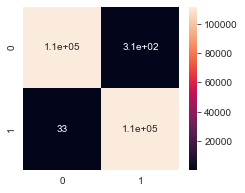

In [36]:
# Visualise confusion matrix
plt.figure(figsize=(3.5,3))
sns.heatmap(m, annot=True)

In [37]:
# View precision, recall and f1-score
from sklearn.metrics import classification_report
print(classification_report(y, predicted1))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    112031
         1.0       1.00      1.00      1.00    112031

    accuracy                           1.00    224062
   macro avg       1.00      1.00      1.00    224062
weighted avg       1.00      1.00      1.00    224062



In [38]:
# Calculate AUC score
from sklearn.metrics import roc_auc_score
roc_auc1 = roc_auc_score(y, predicted1)
print("Area under the ROC curve : %f" % roc_auc1)

Area under the ROC curve : 0.998474


In [39]:
### Model Estimation and Optimisation ###

from sklearn.model_selection import GridSearchCV, train_test_split

# Construct the combinations of parameters
X_train, X_test, y_train, y_test 
= train_test_split(X, y, test_size=0.2, random_state=0)
param_grid = {'C': [0.01,0.1, 1, 10, 100, 1000], 
              'penalty': [ 'l1', 'l2']}

# Determine the model LogisticRegression and the param_grid
grid_search = GridSearchCV(LogisticRegression(),  param_grid)
grid_search.fit(X_train, y_train)

# Evaluate model performance
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.5f}".format(grid_search.best_score_))

Best parameters: {'C': 100, 'penalty': 'l2'}
Best cross-validation score: 0.61160


In [40]:
# Re-check the indicators after adjusting parameters
y_pred = grid_search.predict(X_test)
print("Test set accuracy score: {:.5f}".format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))
roc_auc2 = roc_auc_score(y_test, y_pred)
print("Area under the ROC curve : %f" % roc_auc2)

Test set accuracy score: 0.61018
              precision    recall  f1-score   support

         0.0       0.60      0.66      0.63     22428
         1.0       0.62      0.56      0.59     22385

    accuracy                           0.61     44813
   macro avg       0.61      0.61      0.61     44813
weighted avg       0.61      0.61      0.61     44813

Area under the ROC curve : 0.610134
